# Single Integral Comparison

*David Thomas 2017/03/29*

Abstract

# Setup

Inference and data.

# Methods

Below we discuss four different techniques for computing the likelihood. The code corresponding to each can be found in bigmali.likelihood.

#### Numerical Integration

\begin{align*}
\mathcal{L}(L_{obs}|\alpha, S, \sigma_{obs}, z) &= \iint\ dLdM\ P(L_{obs}|L, \sigma_{obs})P(L|M, \alpha, S, z)P(M|z)\\
&= \sum_{M=min(MP)}^{max(MP)}\sum_{L = min(L_{obs})}^{max(L_{obs})}\ \Delta_M\Delta_L\ P(L_{obs}|L, \sigma_{obs})P(L|M, \alpha, S, z)P(M|z)\\
\end{align*}


#### Simple Monte Carlo Integration

\begin{align*}
\mathcal{L}(L_{obs}|\alpha, S, \sigma_{obs},z) &= \iint dLdM\ P(L_{obs}|L, \sigma_{obs})P(L|M, \alpha, S, z)P(M|z)\\
&= \frac{1}{N_s}\sum_{M \sim\ P(M|z)}\sum_{L \sim\ P(L|M, \alpha, S, z)} P(L_{obs}|L, \sigma_{obs})\\
\end{align*}

#### Importance Sampling Integration

\begin{align*}
\mathcal{L}(L_{obs}|\alpha, S, \sigma_{obs},z,c) &= \iint dLdM \frac{P(L_{obs}|L, \sigma_{obs})P(L|M, \alpha, S, z)P(M|z)Q(L|L_{obs}, \sigma_{obs})Q(M|L,\alpha, S, z, c)}{Q(L|L_{obs}, \sigma_{obs})Q(M|L,\alpha, S, z, c)}\\
&= \frac{1}{N_s}\sum_{(M,L) \sim\ (Q(M|L,\alpha, S, z, c), Q(L|L_{obs}, \sigma_{obs}))}\frac{P(L_{obs}|L, \sigma_{obs})P(L|M, \alpha, S, z)P(M|z)}{Q(L|L_{obs}, \sigma_{obs})Q(M|L,\alpha, S, z, c)}\\
\end{align*}


#### Laplace Approximation Integration

Let 
$$f(M,L) = \ln P(L_{obs}|L, \sigma_{obs}) + \ln P(L|M, \alpha, S, z) + \ln P(M|z)$$

Then we use a Quasi-Newton method to solve 

$$\ln M_{opt},\ln L_{opt}, H_{ln\ opt}^{-1} = \text{argmin}_{\ln M,\ln L} -\left[f(M,L)\right]$$

where we optimize over logarithmic mass and luminosity because otherwise the numerical disparity between mass and luminosity leads to an inaccurate diagonal hessian. Then by the chain rule we have 

$$-\frac{\partial^2 f}{\partial M \partial L} = -\frac{\partial^2 f}{\partial \ln M \partial \ln L} \frac{\partial \ln M}{\partial M} \frac{\partial \ln L}{\partial L} = -\frac{1}{ML}\frac{\partial^2 f}{\partial \ln M \partial \ln L}$$

Hence our desired Hessian is

$$H_{opt} = (H_{ln\ opt}^{-1})^{-1} \odot \begin{pmatrix}M_{opt}^{-2} & M_{opt}^{-1}L_{opt}^{-1}\\ M_{opt}^{-1}L_{opt}^{-1} & L_{opt}^{-2} \end{pmatrix}$$

where $\odot$ is elementwise multiplication. Then we can approximate the likelihood as 

$$\mathcal{L}(L_{obs}|\alpha, S, \sigma_{obs}, z) = \exp(f(M_{opt}, L_{opt}))\sqrt{\frac{(2\pi)^2}{\det(H_{opt})}}$$

To test this approximation we can also see how well $f(M,L)$ is approximated by its Gaussian approximation

$$f(M_{opt}, L_{opt})\exp(\frac{-1}{2}((M,L) - (M_{opt}, L_{opt}))^T H((M,L) - (M_{opt}, L_{opt}))$$


In [237]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import rc
from matplotlib import cm
import matplotlib.colors as colors
from bigmali.grid import Grid
from bigmali.likelihood import BiasedLikelihood
from bigmali.prior import TinkerPrior
from bigmali.hyperparameter import get
from scipy.stats import lognorm
from time import time
import seaborn.apionly as sns
from scipy.optimize import minimize
from math import sqrt
from time import time
rc('text', usetex=True)

data = pd.read_csv('/Users/user/Code/PanglossNotebooks/MassLuminosityProject/mock_data.csv')

prior = TinkerPrior(Grid())

def p1(lobs, lum, sigma):
    return fast_lognormal(lum, sigma, lobs)

def p2(lum, mass, a1, a2, a3, a4, S, z):
    mu_lum = np.exp(a1) * ((mass / a3) ** a2) * ((1 + z) ** (a4))
    return fast_lognormal(mu_lum, S, lum)
    
def p3(mass, z):
    return prior.fetch(z).pdf(mass)

def q1(lum, lobs, sigma):
    return fast_lognormal(lobs, sigma, lum)
    
def q2(mass, lum, a1, a2, a3, a4, S, z):
    mu_mass = a3 * (lum / (np.exp(a1) * (1 + z) ** a4)) ** (1 / a2)
    return fast_lognormal(mu_mass, S, mass)

def logp1(lobs, lum, sigma):
    return fast_log_lognormal(lum, sigma, lobs)

def logp2(lum, mass, a1, a2, a3, a4, S, z):
    mu_lum = np.exp(a1) * ((mass / a3) ** a2) * ((1 + z) ** (a4))
    return fast_log_lognormal(mu_lum, S, lum)

def logp3(mass, z):
    return prior.fetch(z).logpdf(mass)


def midpoints(arr):
    n = len(arr)-1
    ret = np.zeros(n)
    for i in xrange(n):
        ret[i] = (arr[i+1] + arr[i]) / 2.
    return ret

def fast_lognormal(mu, sigma, x):
    return  (1/(x * sigma * np.sqrt(2 * np.pi))) * np.exp(- 0.5 * (np.log(x) - np.log(mu)) ** 2 / sigma ** 2)

def fast_log_lognormal(mu, sigma, x):
    return  -np.log(x * sigma * np.sqrt(2 * np.pi)) - 0.5 * (np.log(x) - np.log(mu)) ** 2 / sigma ** 2

def log10(arr):
    return np.log(arr) / np.log(10)

def toColor(weights, integrands):
    #first we log-normalize to interval [0,1]
    lw = np.log(weights + 1e-30)
    li = np.log(integrands + 1e-30)
    nlw = (lw - lw.min()) / (lw.max() - lw.min())
    nli = (li - li.min()) / (li.max() - li.min())
    colors = np.zeros((len(weights), 4))
    for i in xrange(len(weights)):
        colors[i,:] = cm.coolwarm(255 * nlw[i], nli[i])
    return colors

def numerical_integration(a1, a2, a3, a4, S, nsamples=10**3):
    masses = midpoints(prior.fetch(true_z).mass[1:])
    delta_masses = np.diff(prior.fetch(true_z).mass[1:])
    lums_tmp = np.logspace(log10(np.min(data.lum_obs)), log10(np.max(data.lum_obs)), nsamples)
    lums = midpoints(lums_tmp)
    delta_lums = np.diff(lums_tmp)
    integral = 0
    for i,lum in enumerate(lums):
        integral += np.sum(delta_masses * delta_lums[i] * p1(true_lum_obs, lum, sigma) * \
            p2(lum, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z))
    return integral

def simple_monte_carlo_integration(a1, a2, a3, a4, S, nsamples=10**6):
    masses = prior.fetch(true_z).rvs(nsamples)
    mu_lum = np.exp(a1) * ((masses / a3) ** a2) * ((1 + true_z) ** (a4))
    lums = lognorm(S, scale=mu_lum).rvs()
    return np.sum(p1(true_lum_obs, lums, sigma)) / (nsamples)

def importance_sampling_integration(a1, a2, a3, a4, S, nsamples=10**6):
    rev_S = 5.6578015811698101 * S
    lums = lognorm(sigma, scale=true_lum_obs).rvs(size=nsamples)
    mu_mass = a3 * (lums / (np.exp(a1) * (1 + true_z) ** a4)) ** (1 / a2)
    masses = lognorm(rev_S, scale=mu_mass).rvs()
    integral = np.sum((p1(true_lum_obs, lums, sigma) * \
            p2(lums, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z)) / \
                (q1(lums, true_lum_obs, sigma) * q2(masses, lums, a1, a2, a3, a4, rev_S, true_z))) /\
            len(lums)
    return integral

def neg_log_integrand(prms):
    mass, lum = np.exp(prms)
    return \
    - logp1(true_lum_obs, lum, sigma) \
    - logp2(lum, mass, a1, a2, a3, a4, S, true_z) \
    - logp3(mass, true_z)

def laplace_approximation(a1, a2, a3, a4, S):
    x0 = [np.log(10**11), np.log(10**4.0)]
    ans = minimize(neg_log_integrand, x0, method='BFGS')
    h = np.linalg.inv(ans['hess_inv'])
    h[0,0] = h[0,0] * (1/np.exp(ans['x'][0])) ** 2
    h[1,0] = h[1,0] * (1/np.exp(ans['x'][0])) * (1/np.exp(ans['x'][1]))
    h[0,1] = h[1,0]
    h[1,1] = h[1,1] * (1/np.exp(ans['x'][1])) ** 2
    return np.exp(-neg_log_integrand(ans['x'])) * sqrt((2 * np.pi) ** 2/ np.linalg.det(h))

def numerical_integration_grid(a1, a2, a3, a4, S):
    nsamples = 100
    masses = midpoints(prior.fetch(true_z).mass[1:-1])
    delta_masses = np.diff(prior.fetch(true_z).mass[1:-1])
    lums_tmp = np.logspace(log10(np.min(data.lum_obs)), log10(np.max(data.lum_obs)), nsamples)
    lums = midpoints(lums_tmp)
    delta_lums = np.diff(lums_tmp)
    sigma = 0.05
    integral = 0
    ans = np.zeros((len(lums)*len(masses),3))
    count = 0
    for i, lum in enumerate(lums):
        for j, mass in enumerate(masses):
            ans[count,0] = lum
            ans[count,1] = mass
            ans[count,2] = np.sum(delta_masses[j] * delta_lums[i] * p1(true_lum_obs, lum, sigma) * \
            p2(lum, mass, a1, a2, a3, a4, S, true_z) * p3(mass, true_z))
            count += 1
    return ans

def simple_monte_carlo_integration_samples(a1, a2, a3, a4, S, nsamples=10**3):
    sigma = 0.05
    masses = prior.fetch(true_z).rvs(nsamples)
    mu_lum = np.exp(a1) * ((masses / a3) ** a2) * ((1 + true_z) ** (a4))
    lums = lognorm(S, scale=mu_lum).rvs()
    weights = p1(true_lum_obs, lums, sigma)
    integrands = p1(true_lum_obs, lums, sigma) * p2(lums, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z)
    return masses, lums, weights, integrands

def importance_sampling_integration_samples(a1, a2, a3, a4, S, nsamples=10**3):
    rev_S = 5.6578015811698101 * S
    lums = lognorm(sigma, scale=true_lum_obs).rvs(size=nsamples)
    mu_mass = a3 * (lums / (np.exp(a1) * (1 + true_z) ** a4)) ** (1 / a2)
    masses = lognorm(rev_S, scale=mu_mass).rvs()
    weights = (p1(true_lum_obs, lums, sigma) * \
            p2(lums, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z)) / \
                (q1(lums, true_lum_obs, sigma) * q2(masses, lums, a1, a2, a3, a4, rev_S, true_z))
    integrands = p1(true_lum_obs, lums, sigma) * \
            p2(lums, masses, a1, a2, a3, a4, S, true_z) * p3(masses, true_z)
    return masses, lums, weights, integrands

a1,a2,a3,a4,S = get()
sigma = 0.05

def fix_point(idx):
    true_mass = data.mass.ix[idx]
    true_z = data.z.ix[idx]
    true_lum = data.lum.ix[idx]
    true_lum_obs = data.lum_obs.ix[idx]
    true_lum_obs_collection = data.lum_obs

def make_plot_panel():
    plt.subplot(1,3,1)
    grid = numerical_integration_grid(a1,a2,a3,a4,S)
    step = 1
    epsilon = 1e-20
    gridv = np.maximum(grid[::step,2], epsilon)
    x = log10(grid[::step,0])
    y = log10(grid[::step,1])
    scat = plt.scatter(y, x, marker='s', s=40, alpha=0.8, c=gridv, norm=colors.LogNorm(), cmap='coolwarm', lw=0);
    plt.gcf().set_size_inches((6,6))
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.scatter(log10(true_mass), log10(true_lum_obs), color='black', s=50, label='Halo')
    # plt.scatter(x[22723], y[22723], color='gold', s=50, label='MaximumWeight')
    plt.legend()
    plt.gcf().colorbar(scat)
    plt.title('Numerical Integration Weights')
    plt.xlabel('Mass $(\log_{10}(M))$')
    plt.ylabel('Luminosity $(\log_{10}(L))$')
    
    plt.subplot(1,3,2)
    m, l, w, i = simple_monte_carlo_integration_samples(a1, a2, a3, a4, S, nsamples=10**3)
    scat = plt.scatter(log10(m), log10(l), c=toColor(w,i), lw=0)
    scat = plt.scatter(log10(true_mass), log10(true_lum_obs), color='black', s=50)
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.title('Simple Monte Carlo Weights')
    plt.xlabel('Mass ($\log_{10}(M)$)')
    plt.ylabel('Luminosity ($\log_{10}(L)$)')
    
    plt.subplot(1,3,3)
    m, l, w, i = importance_sampling_integration_samples(a1, a2, a3, a4, S, nsamples=10**3)
    plt.scatter(log10(m), log10(l), c=toColor(w,i), lw=0)
    plt.scatter(log10(true_mass), log10(true_lum_obs), color='black', s=50)
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.title('Importance Sampling Weights')
    plt.xlabel('Mass ($\log_{10}(M)$)')
    plt.ylabel('Luminosity ($\log_{10}(L)$)')
    
    plt.gcf().set_size_inches((12,3))

# Characterizing Approaches over Four Distinct Points

### Selecting Points
We start by isolating four points in different regions of the M-L plane that we will use in testing below.

In [3]:
dat = np.array([np.arange(len(data.mass)), log10(data.mass), log10(data.lum)]).transpose()
datr = np.random.permutation(dat)

In [4]:
idx = (datr[:,1] < 11.2) & (datr[:,1] > 11.0) & (datr[:,2] > 3.8) & (datr[:,2] < 4.0)
datr[idx]

array([[  5.19130000e+04,   1.11995544e+01,   3.90565383e+00],
       [  7.40620000e+04,   1.11673694e+01,   3.93304135e+00],
       [  7.94170000e+04,   1.10103403e+01,   3.97087604e+00],
       ..., 
       [  2.49600000e+03,   1.10582255e+01,   3.90617323e+00],
       [  6.76990000e+04,   1.11346137e+01,   3.90150384e+00],
       [  8.04710000e+04,   1.10746143e+01,   3.81411623e+00]])

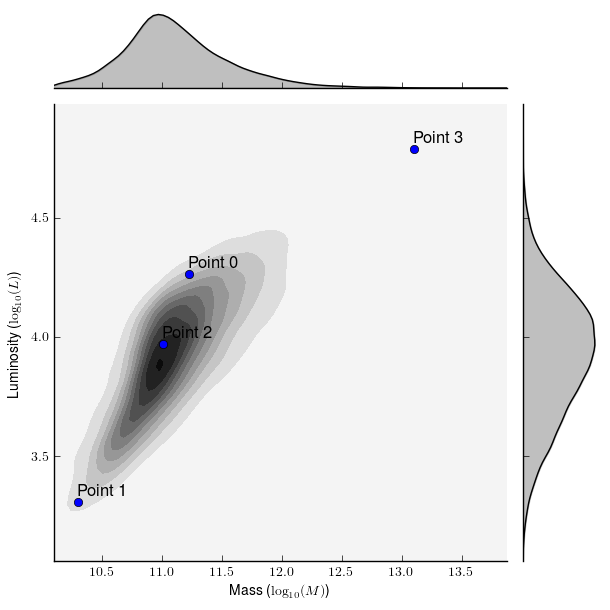

In [179]:
inds = [115916, 103133, 79417, 13008]

ax = sns.jointplot(x=datr[:30000,1], y=datr[:30000,2], kind="kde", color='black');
# ax.ax_joint.scatter(dat[:,1][:1000], dat[:,2][:1000], alpha=0.4, marker='x', s=10, lw=1, c='gray')
for i,ind in enumerate(inds):
    ax.ax_joint.plot(dat[ind,1], dat[ind,2], marker='o', color='blue')
    ax.ax_joint.text(dat[ind,1], dat[ind,2]+0.03, "Point %d" % i, ha ='left', fontsize = 12, color='black')
ax.ax_joint.legend_.remove()
ax.ax_joint.set_ylabel('Luminosity ($\log_{10}(L)$)')
ax.ax_joint.set_xlabel('Mass ($\log_{10}(M)$)')
xlim = (datr[:30000, 1].min(), datr[:30000, 1].max())
ylim = (datr[:30000, 2].min(), datr[:30000, 2].max())
ax.ax_joint.set_xlim(xlim)
ax.ax_joint.set_ylim(ylim);

### Point 0

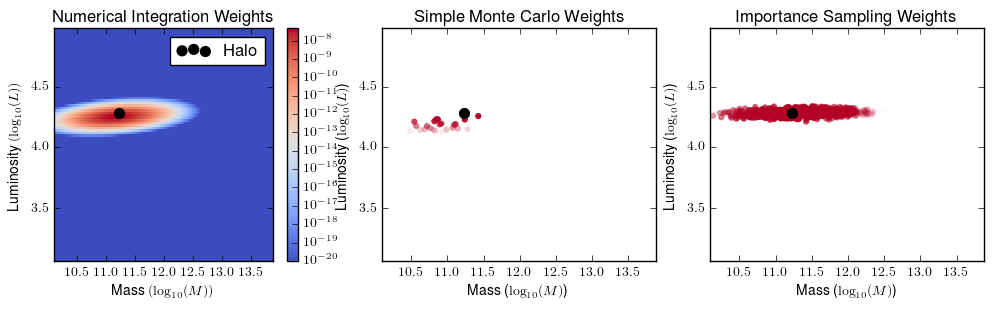

In [226]:
idx = 115916
true_mass = data.mass.ix[idx]
true_z = data.z.ix[idx]
true_lum = data.lum.ix[idx]
true_lum_obs = data.lum_obs.ix[idx]
true_lum_obs_collection = data.lum_obs
make_plot_panel()

Note to Phil: I want to add the BFGS path for laplace approximation to this panel.

In [227]:
print 'numerical integration: {}'.format(numerical_integration(a1,a2,a3,a4,S,nsamples=10**4))
print 'simple monte carlo: {}'.format(simple_monte_carlo_integration(a1,a2,a3,a4,S,nsamples=10**5))
print 'importance sampling: {}'.format(importance_sampling_integration(a1,a2,a3,a4,S,nsamples=10**5))
print 'laplace approximation: {}'.format(laplace_approximation(a1,a2,a3,a4,S))

numerical integration: 6.40358058377e-06
simple monte carlo: 9.36749785967e-07
importance sampling: 6.42347469458e-06
laplace approximation: 3.68701955823e-06


### Point 1

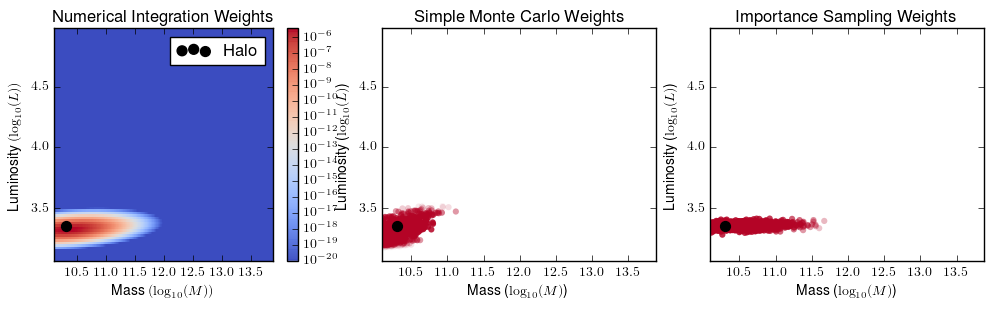

In [228]:
idx = 103133
true_mass = data.mass.ix[idx]
true_z = data.z.ix[idx]
true_lum = data.lum.ix[idx]
true_lum_obs = data.lum_obs.ix[idx]
true_lum_obs_collection = data.lum_obs
make_plot_panel()

In [229]:
print 'numerical integration: {}'.format(numerical_integration(a1,a2,a3,a4,S,nsamples=10**4))
print 'simple monte carlo: {}'.format(simple_monte_carlo_integration(a1,a2,a3,a4,S,nsamples=10**5))
print 'importance sampling: {}'.format(importance_sampling_integration(a1,a2,a3,a4,S,nsamples=10**5))
print 'laplace approximation: {}'.format(laplace_approximation(a1,a2,a3,a4,S))

numerical integration: 0.000487808661776
simple monte carlo: 0.000484449421901
importance sampling: 0.000487038502582
laplace approximation: 0.000316487709918


### Point 2

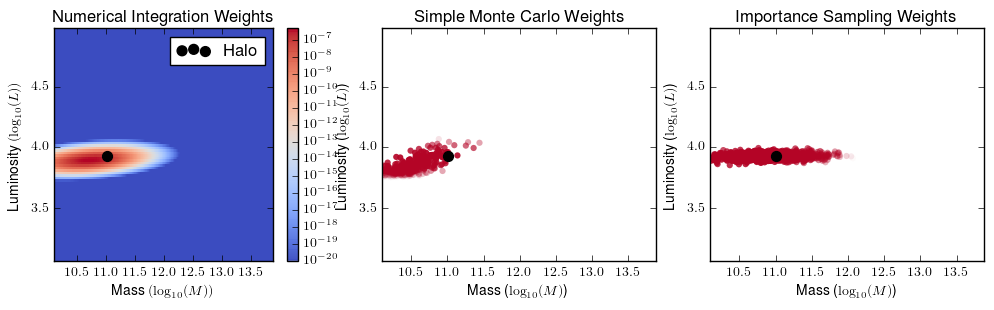

In [230]:
idx = 79417
true_mass = data.mass.ix[idx]
true_z = data.z.ix[idx]
true_lum = data.lum.ix[idx]
true_lum_obs = data.lum_obs.ix[idx]
true_lum_obs_collection = data.lum_obs
make_plot_panel()

In [231]:
print 'numerical integration: {}'.format(numerical_integration(a1,a2,a3,a4,S,nsamples=10**4))
print 'simple monte carlo: {}'.format(simple_monte_carlo_integration(a1,a2,a3,a4,S,nsamples=10**5))
print 'importance sampling: {}'.format(importance_sampling_integration(a1,a2,a3,a4,S,nsamples=10**5))
print 'laplace approximation: {}'.format(laplace_approximation(a1,a2,a3,a4,S))

numerical integration: 6.27613065943e-05
simple monte carlo: 2.75165076028e-05
importance sampling: 6.28101952316e-05
laplace approximation: 3.80374065466e-05


### Point 3

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:71: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:72: RuntimeWarning: invalid value encountered in divide


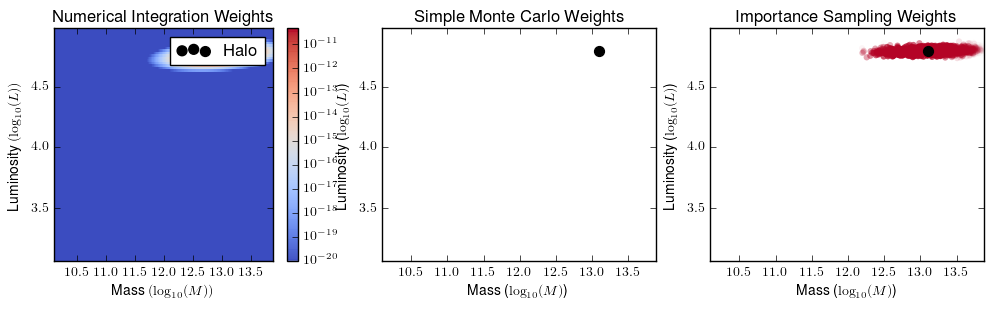

In [232]:
idx = 13008
true_mass = data.mass.ix[idx]
true_z = data.z.ix[idx]
true_lum = data.lum.ix[idx]
true_lum_obs = data.lum_obs.ix[idx]
true_lum_obs_collection = data.lum_obs
make_plot_panel()

In [233]:
print 'numerical integration: {}'.format(numerical_integration(a1,a2,a3,a4,S,nsamples=10**4))
print 'simple monte carlo: {}'.format(simple_monte_carlo_integration(a1,a2,a3,a4,S,nsamples=10**5))
print 'importance sampling: {}'.format(importance_sampling_integration(a1,a2,a3,a4,S,nsamples=10**5))
print 'laplace approximation: {}'.format(laplace_approximation(a1,a2,a3,a4,S))

numerical integration: 5.57536196939e-09
simple monte carlo: 4.51723905004e-55
importance sampling: 5.59223478278e-09
laplace approximation: 2.89024212204e-09


# Convergence

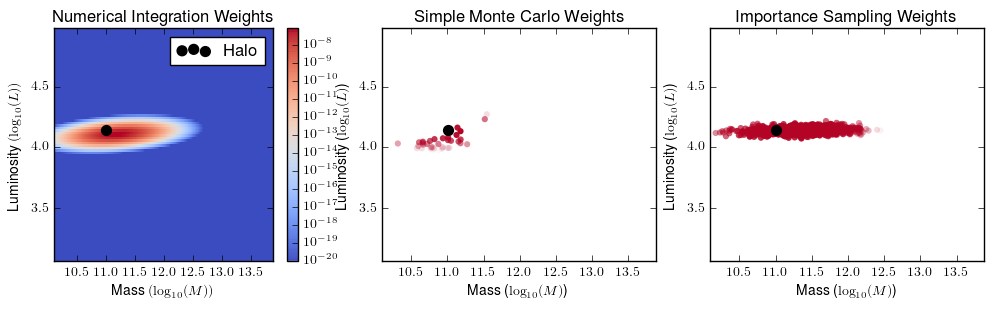

In [240]:
idx = 0
true_mass = data.mass.ix[idx]
true_z = data.z.ix[idx]
true_lum = data.lum.ix[idx]
true_lum_obs = data.lum_obs.ix[idx]
true_lum_obs_collection = data.lum_obs
make_plot_panel()

In [241]:
n = 15
vals = np.zeros((n+1, 3))
timevals = np.zeros((n+1, 3))
logspace = np.append([5], np.logspace(1, 5, n))
for i, nsamples in enumerate(logspace):
    nsamples = int(nsamples)
    start = time()
    vals[i][0] = numerical_integration(a1,a2,a3,a4,S, nsamples=nsamples)
    end = time()
    timevals[i][0] = end - start
    
    start = time()
    vals[i][1] = simple_monte_carlo_integration(a1,a2,a3,a4,S, nsamples=nsamples)
    end = time()
    timevals[i][1] = end - start
    
    start = time()
    vals[i][2] = importance_sampling_integration(a1,a2,a3,a4,S, nsamples=nsamples)
    end = time()
    timevals[i][2] = end - start

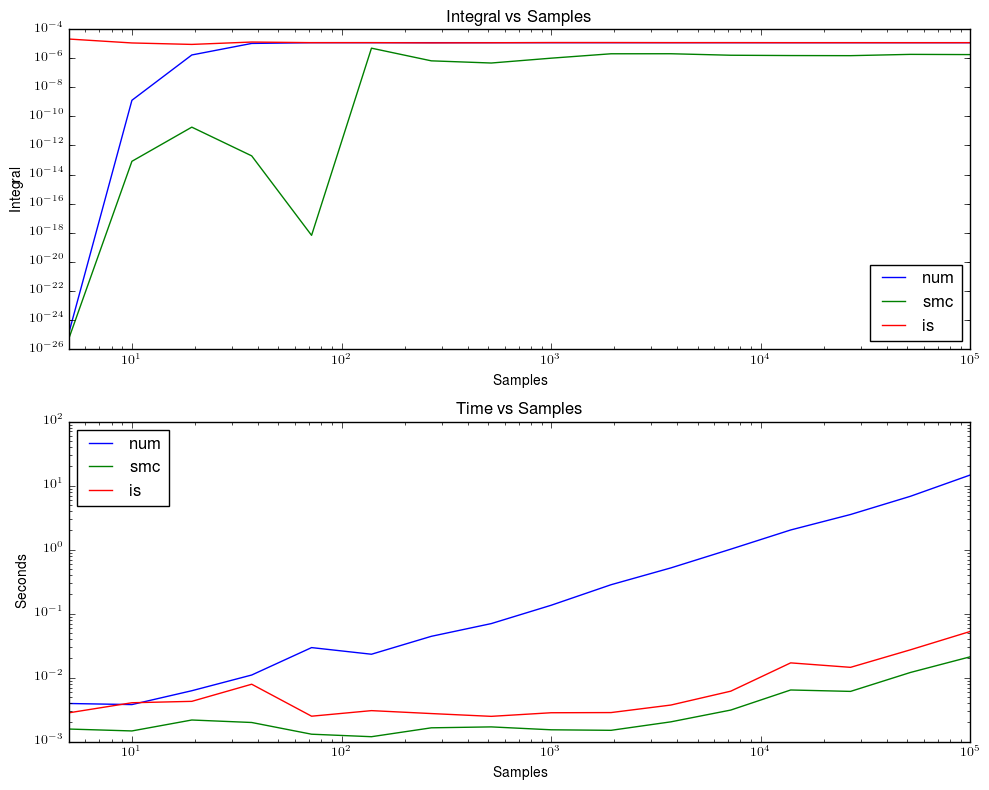

In [242]:
plt.subplot(211)
plt.plot(logspace, vals[:,0], label='num')
plt.plot(logspace, vals[:,1], label='smc')
plt.plot(logspace, vals[:,2], label='is')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.title('Integral vs Samples')
plt.xlabel('Samples')
plt.ylabel('Integral')
plt.xlim([5,10**5])
plt.legend(loc=4)

plt.subplot(212)
plt.plot(logspace, timevals[:,0], label='num')
plt.plot(logspace, timevals[:,1], label='smc')
plt.plot(logspace, timevals[:,2], label='is')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.title('Time vs Samples')
plt.xlabel('Samples')
plt.ylabel('Seconds')
plt.legend(loc=2)
plt.xlim([5,10**5])

plt.gcf().set_size_inches(10,8)
plt.tight_layout();

# Next

- Add the laplace optimization path to the panel plots.
- Compare the posterior maximum-likelihood surface and maximum for these methods.
- Start scaling to multiple halos.